# Training models on campaigns in the same area

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import RMSprop # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import seaborn as sns

In [165]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Prossessing functions

In [166]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [167]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    # prepare test data for plots
    if len(test_campaigns) == 1:
        y_pred = model.predict(X_test, verbose=0) 

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(y_test)
        test[features] = scaler.inverse_transform(test[features])

        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test), :] = y_pred

        train_pred = model.predict(X, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        train[features] = scaler.inverse_transform(train[features])
        _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
        y_train_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train), :] = train_pred

    else:
        test_test = test[test['campaign'] == test_campaigns[0]]
        test_seq, test_test_seq = series_split_sequences(test_test, test_test[target_feature], n_steps_in, n_steps_out)
        y_pred = model.predict(test_seq, verbose=0)

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(test_test_seq)
        test_test[features] = scaler.inverse_transform(test_test[features])

        y_true_plot = test_test[target_feature].values
        y_pred_plot = np.empty_like(test_test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test_test), :] = y_pred

        test_train = train[train['campaign'] == campaigns[0]]
        test_train_seq, test_y_seq = series_split_sequences(test_train, test_train[target_feature], n_steps_in, n_steps_out)
        train_pred = model.predict(test_train_seq, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        test_train[features] = scaler.inverse_transform(test_train[features])
        test_y_seq = scaler_pred.inverse_transform(test_y_seq)

        y_train_plot = test_train[target_feature].values
        train_pred_plot = np.empty_like(test_train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(test_train), :] = train_pred

    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': y_train_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [168]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

In [169]:
# Parameters
tf.random.set_seed(4567)

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [170]:
op1_df = read_dataset('datasets/Op1_merged.csv')
op1_campaigns = op1_df['campaign'].unique().tolist()

op2_df = read_dataset('datasets/Op2_merged.csv')
op2_campaigns = op2_df['campaign'].unique().tolist()


In [171]:
op1_fig = go.Figure()

for campaign in op1_campaigns:
    current_route = op1_df[op1_df['campaign'] == campaign]
    op1_fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=campaign))

op1_fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=op1_df['Longitude'].mean(), lat=op1_df['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
op1_fig.show()

### Overlapping campaigns from Operator 1

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

In [172]:
op1_overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
                 'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
                 'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
                 'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
                 'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
                 'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

op1_overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
                 'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
                 'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
                 'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
                 'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

op1_overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
                 'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
                 'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
                 'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
                 'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

op1_overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
                 'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
                 'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [173]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[1]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[0]])

In [174]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [175]:
# LSTM training
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            # print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)

In [176]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

Combination  loss_final  val_loss_final  \
0                         RSRP, SINR -> RSRP     0.00175         0.00159   
1                         RSRP, RSRQ -> RSRP     0.00181         0.00189   
2                   RSRP, SINR, RSRQ -> RSRP     0.00186         0.00177   
3                     RSRP, SSS_RSRP -> RSRP     0.00180         0.00239   
4                                All -> RSRP     0.00197         0.00290   
5                         RSRP, SINR -> SINR     0.00154         0.00284   
6                         SINR, RSRQ -> SINR     0.00150         0.00262   
7                   RSRP, SINR, RSRQ -> SINR     0.00160         0.00417   
8                     SINR, SSS_SINR -> SINR     0.00185         0.00114   
9                                All -> SINR     0.00165         0.00516   
10                        RSRP, RSRQ -> RSRQ     0.00383         0.00168   
11                        SINR, RSRQ -> RSRQ     0.00358         0.00125   
12                  RSRP, SINR, RSRQ -> RSRQ     0.00349         0.00168   
13                    RSRQ, SSS_RSRQ -> RSRQ     0.00365         0.00141   
14                               All -> RSRQ     0.00370         0.00125   
15            SSS_RSRP, SSS_SINR -> SSS_RSRP     0.00194         0.00134   
16            SSS_RSRP, SSS_RSRQ -> SSS_RSRP     0.00199         0.00134   
17  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP     0.00194         0.00134   
18                RSRP, SSS_RSRP -> SSS_RSRP     0.00194         0.00130   
19                           All -> SSS_RSRP     0.00199         0.00151   
20            SSS_RSRP, SSS_SINR -> SSS_SINR     0.00267         0.00200   
21            SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00255         0.00175   
22  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00242         0.00186   
23                SINR, SSS_SINR -> SSS_SINR     0.00255         0.00196   
24                           All -> SSS_SINR     0.00248         0.00189   
25            SSS_RSRP, SSS_RSRQ -> SSS_RSRQ     0.00285         0.00106   
26            SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00282         0.00079   
27  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00323         0.00081   
28                RSRQ, SSS_RSRQ -> SSS_RSRQ     0.00290         0.00099   
29                           All -> SSS_RSRQ     0.00284         0.00096   

     mae  train_mae  
0   0.39       0.65  
1   0.64       0.89  
2   1.09       1.11  
3   0.94       1.16  
4   1.23       1.26  
5   0.54       0.95  
6   0.47       0.85  
7   0.77       1.11  
8   0.74       0.95  
9   0.74       1.25  
10  0.41       0.46  
11  0.29       0.36  
12  0.45       0.45  
13  0.49       0.52  
14  0.43       0.44  
15  1.01       0.99  
16  1.16       1.09  
17  1.07       1.04  
18  1.03       1.01  
19  1.15       1.11  
20  1.30       1.16  
21  1.24       1.15  
22  1.18       1.07  
23  1.08       1.06  
24  1.31       1.18  
25  0.59       0.48  
26  0.49       0.37  
27  0.52       0.39  
28  0.44       0.37  
29  0.53       0.39

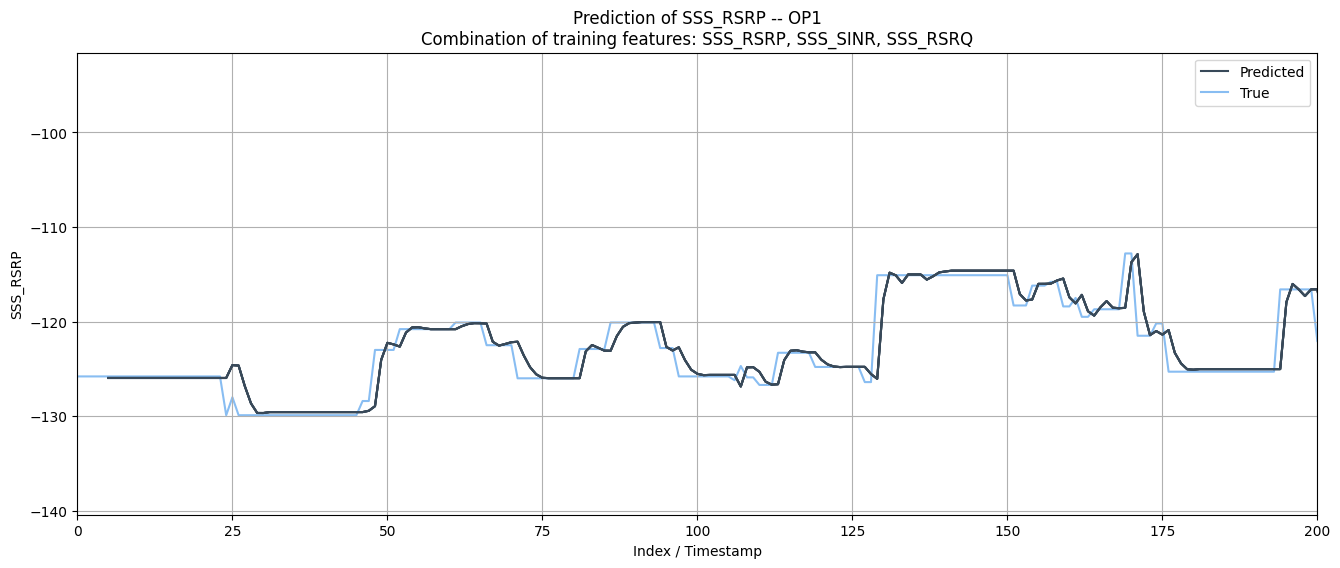

In [177]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

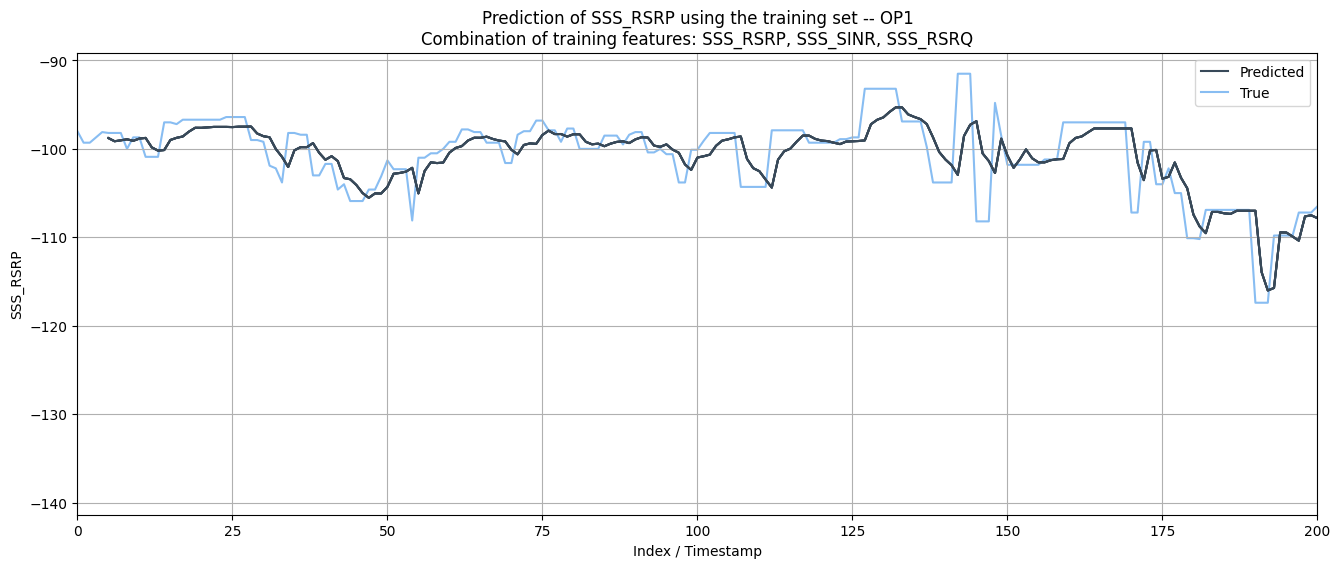

In [178]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- OP1\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [179]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

### Overlap 1

#### Train 1 campaign -- Test 1 campaign

In [180]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.583      0.689   0.139           1.000   
1      n_est: 5, min_leaf: 2     0.546      0.487   0.085           0.999   
2      n_est: 5, min_leaf: 5     0.554      0.529   0.115           0.996   
3      n_est: 5, min_leaf: 7     0.569      0.613   0.126           0.994   
4      n_est: 5, min_leaf: 9     0.555      0.537   0.114           0.987   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.564      0.589   0.116           0.998   
73   n_est: 300, min_leaf: 7     0.556      0.541   0.118           0.995   
74   n_est: 300, min_leaf: 9     0.561      0.572   0.113           0.994   
75  n_est: 300, min_leaf: 12     0.555      0.532   0.118           0.994   
76  n_est: 300, min_leaf: 15     0.552      0.518   0.120           0.991   

    Precision_train  Recall_train  
0             1.000         0.997  
1             1.000         0.995  
2             0.977         0.997  
3             0.972         0.992  
4             0.938         0.992  
..              ...           ...  
72            0.990         0.997  
73            0.977         0.992  
74            0.972         0.992  
75            0.972         0.992  
76            0.957         0.992  

[77 rows x 7 columns]

In [181]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.559
Mean precision: 0.563
Mean recall: 0.110


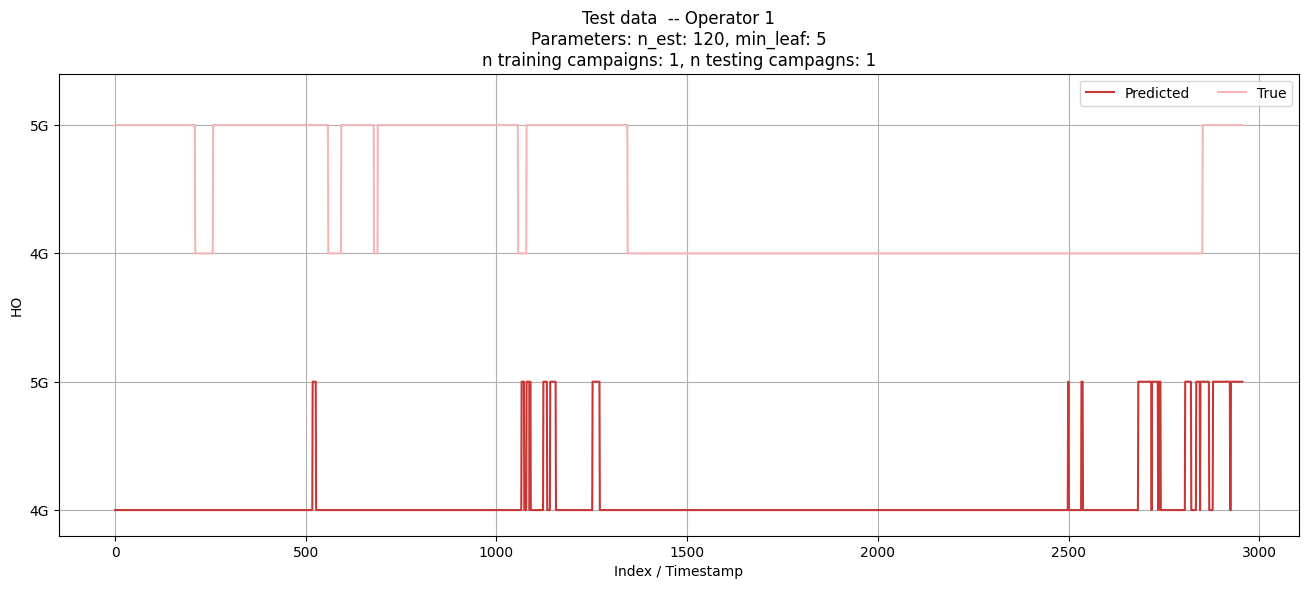

In [182]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data  -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

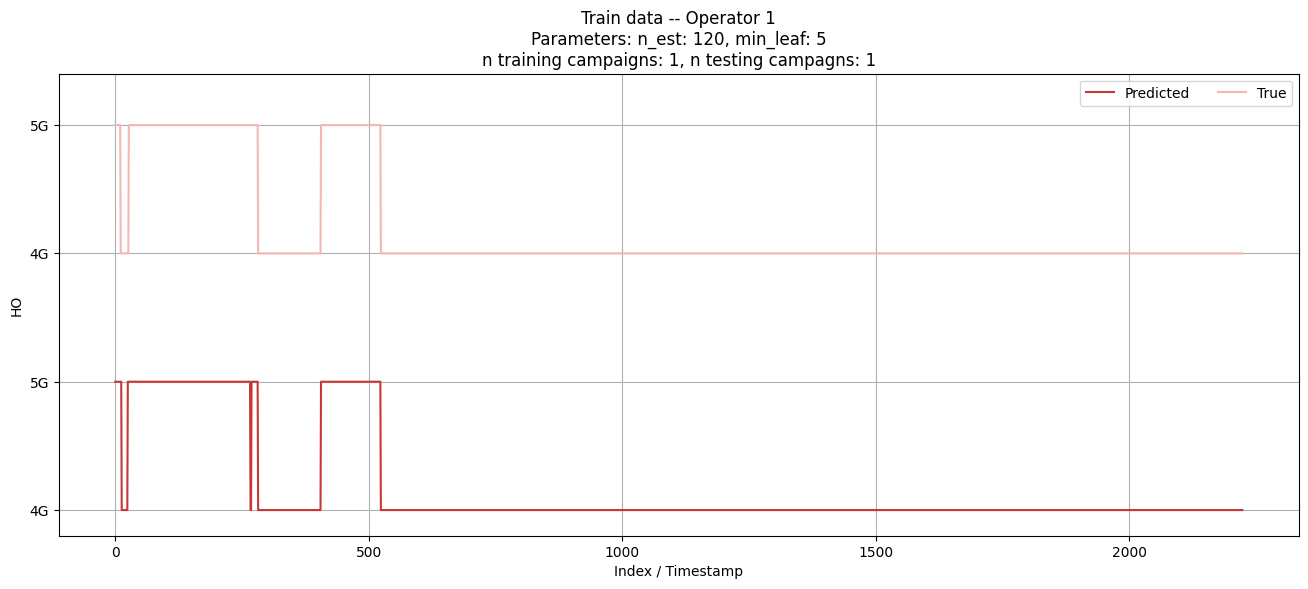

In [183]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

##### Include location

In [184]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.534      0.415   0.079           0.999   
1      n_est: 5, min_leaf: 2     0.545      0.479   0.079           1.000   
2      n_est: 5, min_leaf: 5     0.554      0.541   0.079           0.997   
3      n_est: 5, min_leaf: 7     0.492      0.279   0.079           0.997   
4      n_est: 5, min_leaf: 9     0.491      0.277   0.079           0.990   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.527      0.385   0.079           0.998   
73   n_est: 300, min_leaf: 7     0.527      0.385   0.079           0.996   
74   n_est: 300, min_leaf: 9     0.527      0.385   0.079           0.994   
75  n_est: 300, min_leaf: 12     0.527      0.385   0.079           0.992   
76  n_est: 300, min_leaf: 15     0.527      0.385   0.079           0.992   

    Precision_train  Recall_train  
0             0.997         0.997  
1             1.000         0.997  
2             0.987         0.997  
3             0.985         1.000  
4             0.943         1.000  
..              ...           ...  
72            0.990         1.000  
73            0.980         1.000  
74            0.967         1.000  
75            0.958         1.000  
76            0.958         1.000  

[77 rows x 7 columns]

In [185]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.526
Mean precision: 0.384
Mean recall: 0.079


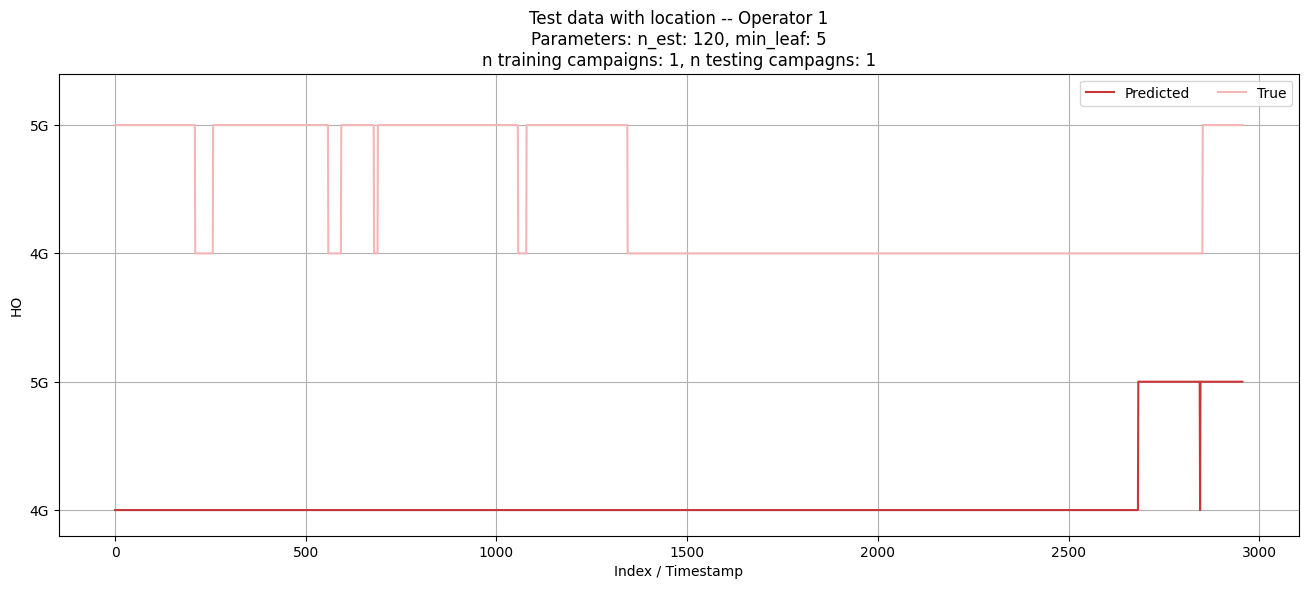

In [186]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

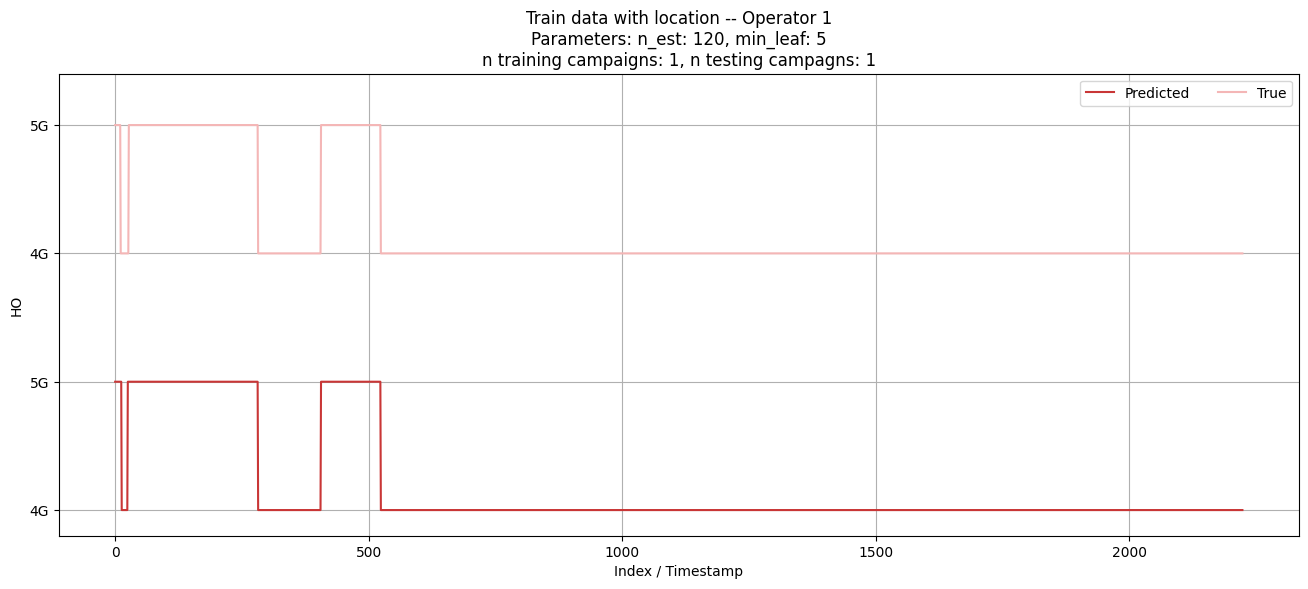

In [187]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 2 campaigns -- Test 1 campaign

In [188]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=op1_overlap_1[1:3])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [189]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.613      0.621   0.369           0.998   
1      n_est: 5, min_leaf: 2     0.672      0.712   0.458           0.997   
2      n_est: 5, min_leaf: 5     0.617      0.631   0.365           0.991   
3      n_est: 5, min_leaf: 7     0.634      0.679   0.359           0.987   
4      n_est: 5, min_leaf: 9     0.600      0.605   0.329           0.982   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.634      0.670   0.376           0.994   
73   n_est: 300, min_leaf: 7     0.637      0.686   0.362           0.992   
74   n_est: 300, min_leaf: 9     0.635      0.673   0.374           0.988   
75  n_est: 300, min_leaf: 12     0.634      0.668   0.377           0.984   
76  n_est: 300, min_leaf: 15     0.635      0.677   0.366           0.983   

    Precision_train  Recall_train  
0             0.996         0.998  
1             0.995         0.995  
2             0.978         0.995  
3             0.973         0.986  
4             0.960         0.985  
..              ...           ...  
72            0.990         0.992  
73            0.984         0.991  
74            0.971         0.991  
75            0.962         0.986  
76            0.962         0.985  

[77 rows x 7 columns]

In [190]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.637
Mean precision: 0.679
Mean recall: 0.371


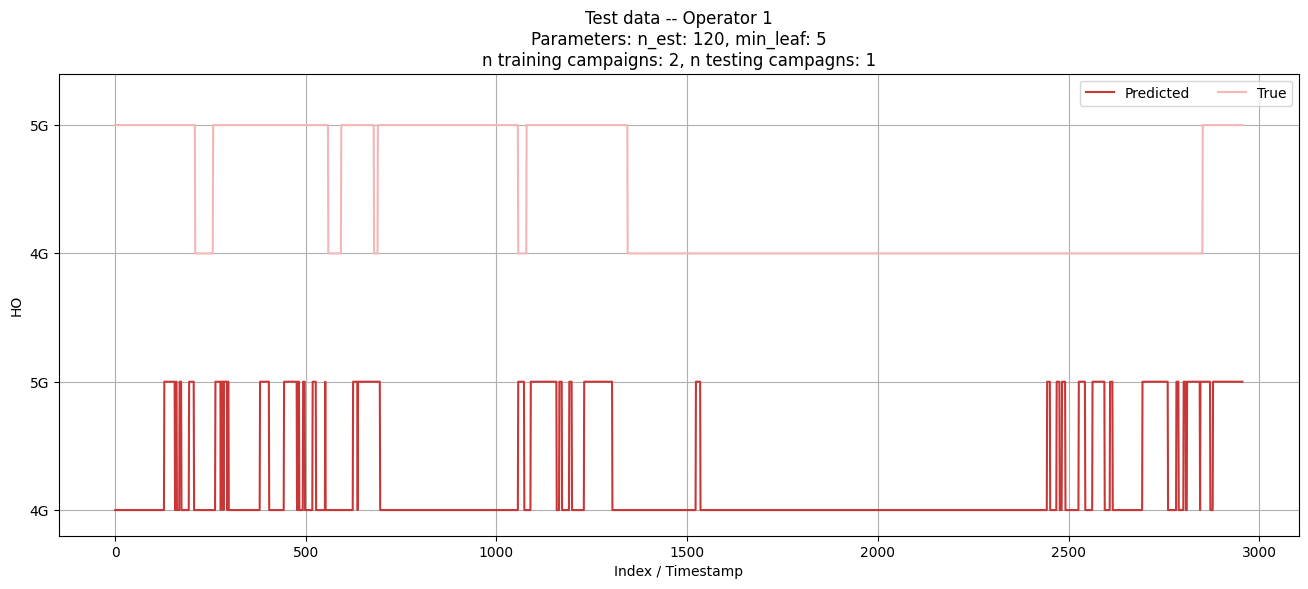

In [191]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

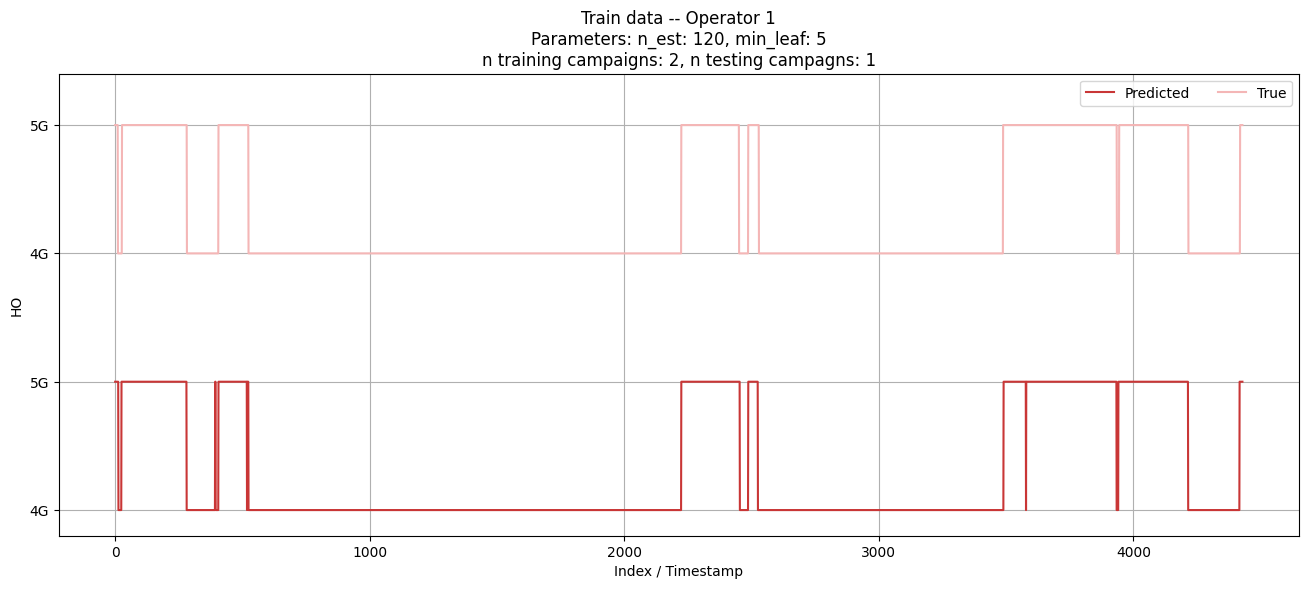

In [192]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [193]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.652      0.704   0.397           0.999   
1      n_est: 5, min_leaf: 2     0.727      0.762   0.577           0.999   
2      n_est: 5, min_leaf: 5     0.751      0.776   0.631           0.997   
3      n_est: 5, min_leaf: 7     0.710      0.731   0.567           0.992   
4      n_est: 5, min_leaf: 9     0.725      0.766   0.564           0.990   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.701      0.751   0.506           0.996   
73   n_est: 300, min_leaf: 7     0.697      0.747   0.497           0.995   
74   n_est: 300, min_leaf: 9     0.698      0.748   0.499           0.992   
75  n_est: 300, min_leaf: 12     0.704      0.757   0.507           0.992   
76  n_est: 300, min_leaf: 15     0.693      0.744   0.490           0.991   

    Precision_train  Recall_train  
0             0.998         0.999  
1             0.999         0.997  
2             0.991         0.999  
3             0.978         0.996  
4             0.977         0.993  
..              ...           ...  
72            0.991         0.998  
73            0.989         0.997  
74            0.978         0.996  
75            0.977         0.997  
76            0.976         0.995  

[77 rows x 7 columns]

In [194]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.699
Mean precision: 0.749
Mean recall: 0.503


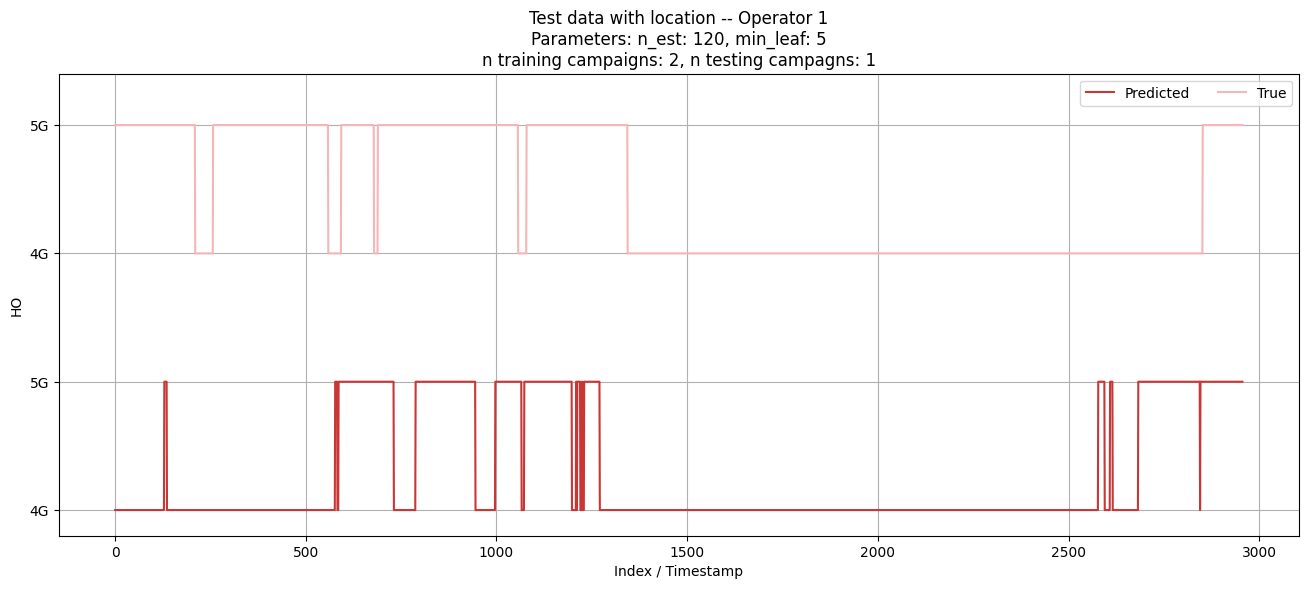

In [195]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 3 campaigns -- Test 1 campaign

In [196]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=op1_overlap_1[1:4])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [197]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.583      0.590   0.252           0.998   
1      n_est: 5, min_leaf: 2     0.609      0.637   0.316           0.997   
2      n_est: 5, min_leaf: 5     0.590      0.612   0.254           0.993   
3      n_est: 5, min_leaf: 7     0.611      0.659   0.288           0.993   
4      n_est: 5, min_leaf: 9     0.665      0.769   0.369           0.986   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.640      0.727   0.326           0.995   
73   n_est: 300, min_leaf: 7     0.644      0.726   0.340           0.992   
74   n_est: 300, min_leaf: 9     0.643      0.720   0.343           0.991   
75  n_est: 300, min_leaf: 12     0.639      0.719   0.329           0.987   
76  n_est: 300, min_leaf: 15     0.634      0.699   0.335           0.986   

    Precision_train  Recall_train  
0             0.995         0.997  
1             0.993         0.996  
2             0.979         0.993  
3             0.980         0.991  
4             0.958         0.989  
..              ...           ...  
72            0.987         0.994  
73            0.978         0.993  
74            0.972         0.991  
75            0.961         0.989  
76            0.958         0.989  

[77 rows x 7 columns]

In [198]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.635
Mean precision: 0.710
Mean recall: 0.325


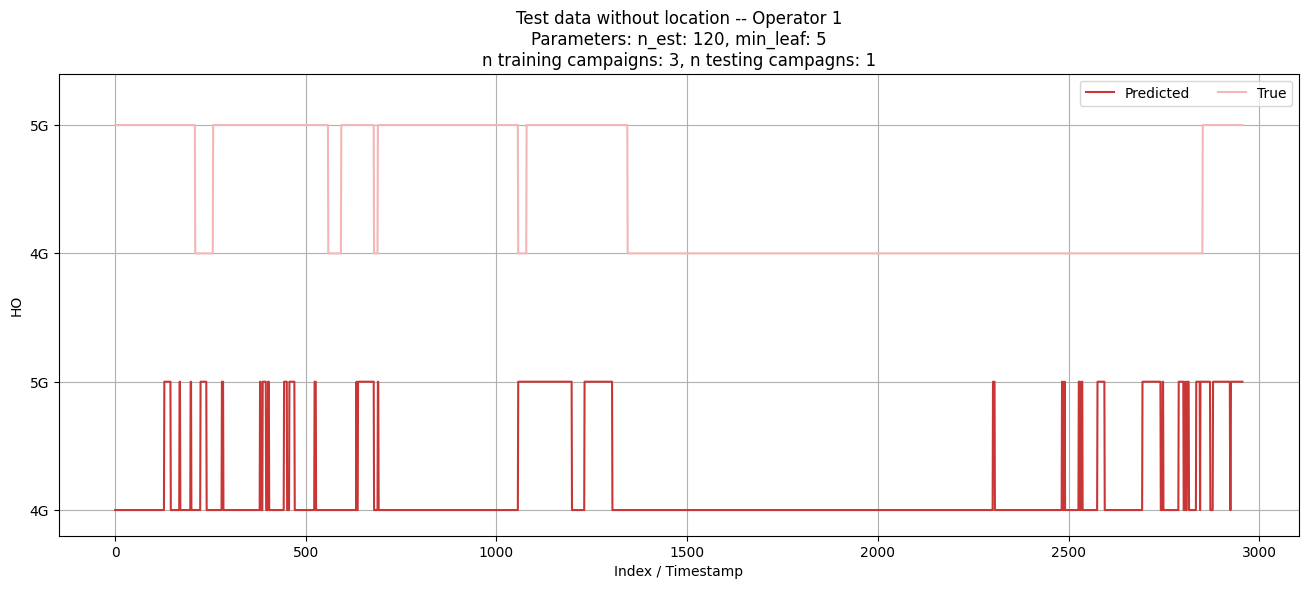

In [199]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [200]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.718      0.927   0.408           0.999   
1      n_est: 5, min_leaf: 2     0.743      0.954   0.452           0.998   
2      n_est: 5, min_leaf: 5     0.716      0.880   0.429           0.994   
3      n_est: 5, min_leaf: 7     0.766      0.894   0.546           0.993   
4      n_est: 5, min_leaf: 9     0.726      0.894   0.446           0.992   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.723      0.958   0.405           0.997   
73   n_est: 300, min_leaf: 7     0.730      0.951   0.424           0.996   
74   n_est: 300, min_leaf: 9     0.715      0.926   0.400           0.995   
75  n_est: 300, min_leaf: 12     0.747      0.930   0.476           0.992   
76  n_est: 300, min_leaf: 15     0.724      0.899   0.439           0.990   

    Precision_train  Recall_train  
0             0.997         0.999  
1             0.995         0.996  
2             0.986         0.993  
3             0.977         0.994  
4             0.980         0.990  
..              ...           ...  
72            0.988         0.999  
73            0.986         0.997  
74            0.983         0.997  
75            0.973         0.996  
76            0.965         0.997  

[77 rows x 7 columns]

In [201]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.715
Mean precision: 0.925
Mean recall: 0.403


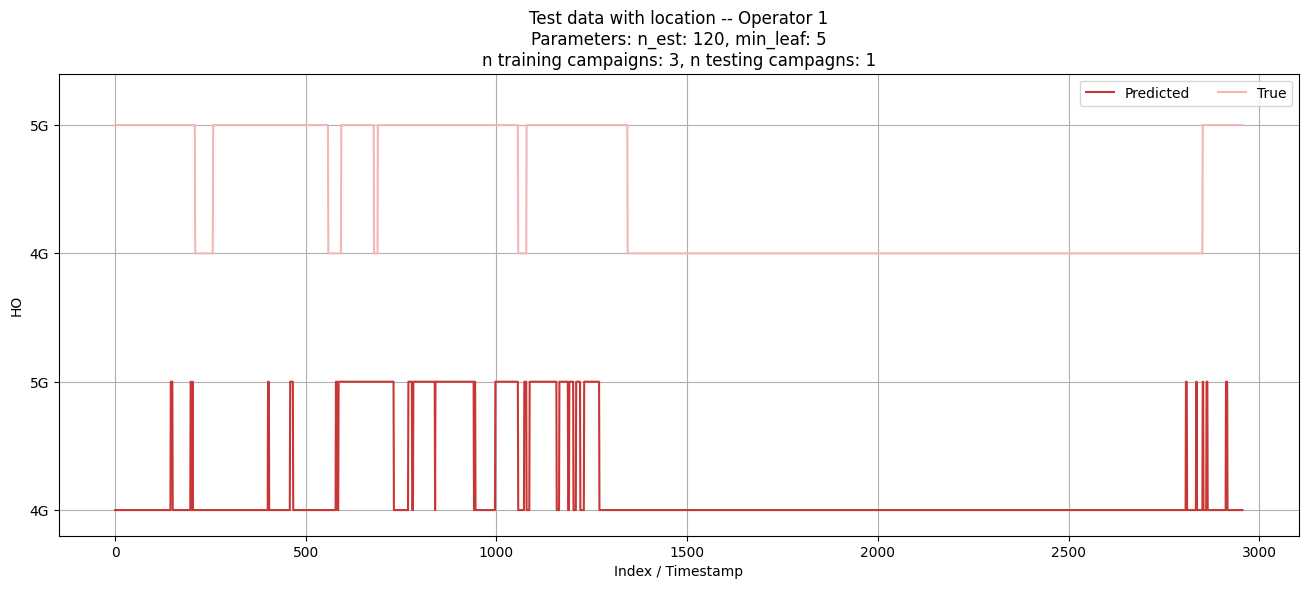

In [202]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 4 campaigns -- Test 1 campaign

In [203]:
new_route = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[4]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[0]])
campaigns.append(op1_overlap_1[4])
test_campaigns = test['campaign'].unique().tolist()

new_route = new_route[5400::]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

In [204]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.605      0.654   0.268           0.998   
1      n_est: 5, min_leaf: 2     0.630      0.718   0.299           0.997   
2      n_est: 5, min_leaf: 5     0.644      0.730   0.338           0.992   
3      n_est: 5, min_leaf: 7     0.637      0.720   0.321           0.990   
4      n_est: 5, min_leaf: 9     0.651      0.728   0.365           0.987   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.642      0.738   0.320           0.995   
73   n_est: 300, min_leaf: 7     0.634      0.718   0.312           0.994   
74   n_est: 300, min_leaf: 9     0.626      0.704   0.297           0.993   
75  n_est: 300, min_leaf: 12     0.631      0.711   0.310           0.990   
76  n_est: 300, min_leaf: 15     0.636      0.718   0.320           0.990   

    Precision_train  Recall_train  
0             0.996         0.995  
1             0.991         0.994  
2             0.975         0.990  
3             0.966         0.989  
4             0.954         0.988  
..              ...           ...  
72            0.984         0.993  
73            0.979         0.991  
74            0.977         0.991  
75            0.969         0.986  
76            0.965         0.989  

[77 rows x 7 columns]

In [205]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.633
Mean precision: 0.718
Mean recall: 0.309


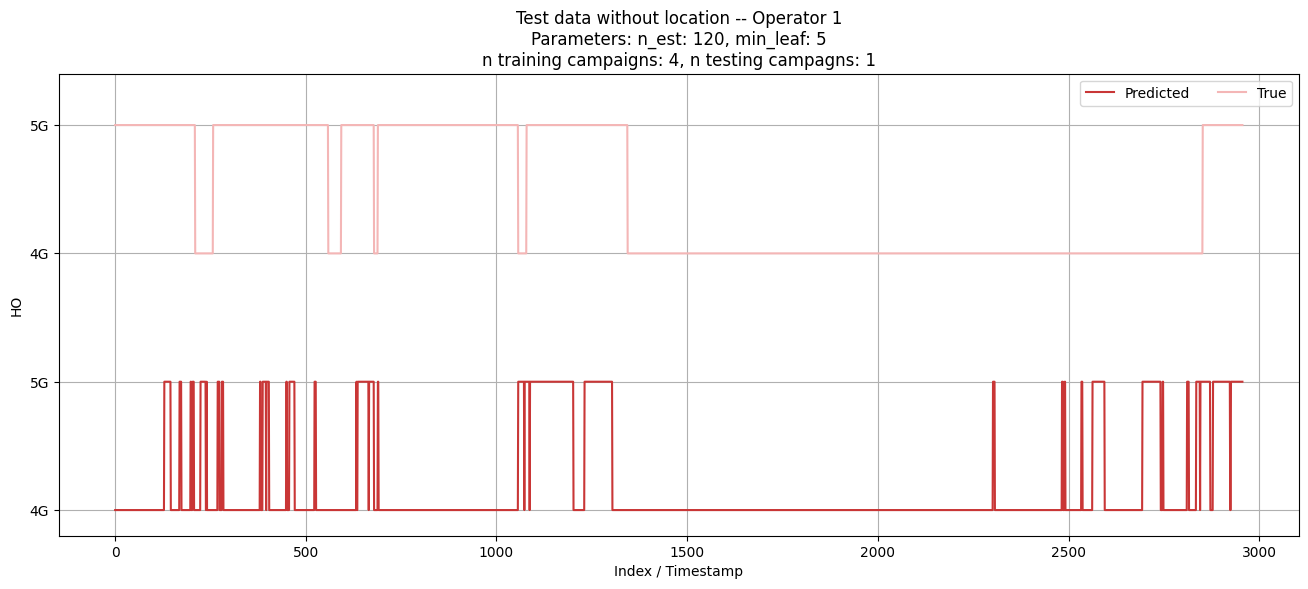

In [206]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [207]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.724      0.895   0.440           0.999   
1      n_est: 5, min_leaf: 2     0.697      0.865   0.389           0.998   
2      n_est: 5, min_leaf: 5     0.680      0.911   0.323           0.995   
3      n_est: 5, min_leaf: 7     0.740      0.948   0.450           0.993   
4      n_est: 5, min_leaf: 9     0.691      0.856   0.379           0.994   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.715      0.959   0.386           0.997   
73   n_est: 300, min_leaf: 7     0.723      0.945   0.412           0.996   
74   n_est: 300, min_leaf: 9     0.717      0.937   0.401           0.995   
75  n_est: 300, min_leaf: 12     0.730      0.943   0.430           0.994   
76  n_est: 300, min_leaf: 15     0.727      0.914   0.437           0.992   

    Precision_train  Recall_train  
0             0.998         0.998  
1             0.993         0.998  
2             0.982         0.996  
3             0.973         0.993  
4             0.978         0.996  
..              ...           ...  
72            0.987         0.999  
73            0.985         0.998  
74            0.980         0.998  
75            0.975         0.996  
76            0.967         0.997  

[77 rows x 7 columns]

In [208]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.710
Mean precision: 0.937
Mean recall: 0.385


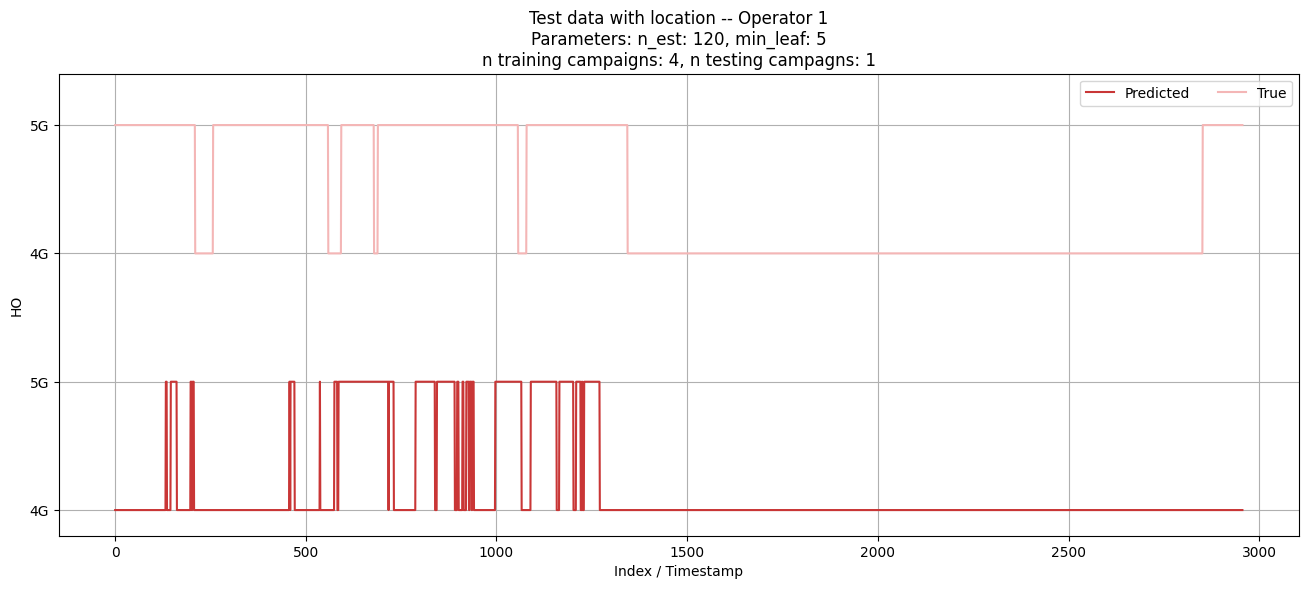

In [209]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 5 campaigns -- Test 1 campaign

In [210]:
new_route = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[5]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_1[0]])
campaigns.append(op1_overlap_1[5])
test_campaigns = test['campaign'].unique().tolist()

new_route = new_route[0:1180]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

op1_fig = go.Figure()

for campaign in campaigns:
    current_route = train[train['campaign'] == campaign]
    op1_fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=campaign))

op1_fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=12,
        center=dict(lon=train['Longitude'].mean(), lat=train['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
op1_fig.show()

In [211]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.608      0.651   0.285           0.998   
1      n_est: 5, min_leaf: 2     0.630      0.689   0.330           0.996   
2      n_est: 5, min_leaf: 5     0.623      0.671   0.323           0.992   
3      n_est: 5, min_leaf: 7     0.621      0.678   0.307           0.987   
4      n_est: 5, min_leaf: 9     0.654      0.738   0.365           0.988   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.652      0.750   0.344           0.995   
73   n_est: 300, min_leaf: 7     0.647      0.723   0.356           0.994   
74   n_est: 300, min_leaf: 9     0.652      0.733   0.360           0.990   
75  n_est: 300, min_leaf: 12     0.653      0.736   0.363           0.988   
76  n_est: 300, min_leaf: 15     0.643      0.709   0.356           0.987   

    Precision_train  Recall_train  
0             0.992         0.997  
1             0.988         0.994  
2             0.973         0.993  
3             0.955         0.989  
4             0.957         0.991  
..              ...           ...  
72            0.984         0.995  
73            0.978         0.994  
74            0.968         0.988  
75            0.958         0.991  
76            0.956         0.988  

[77 rows x 7 columns]

In [212]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.646
Mean precision: 0.726
Mean recall: 0.348


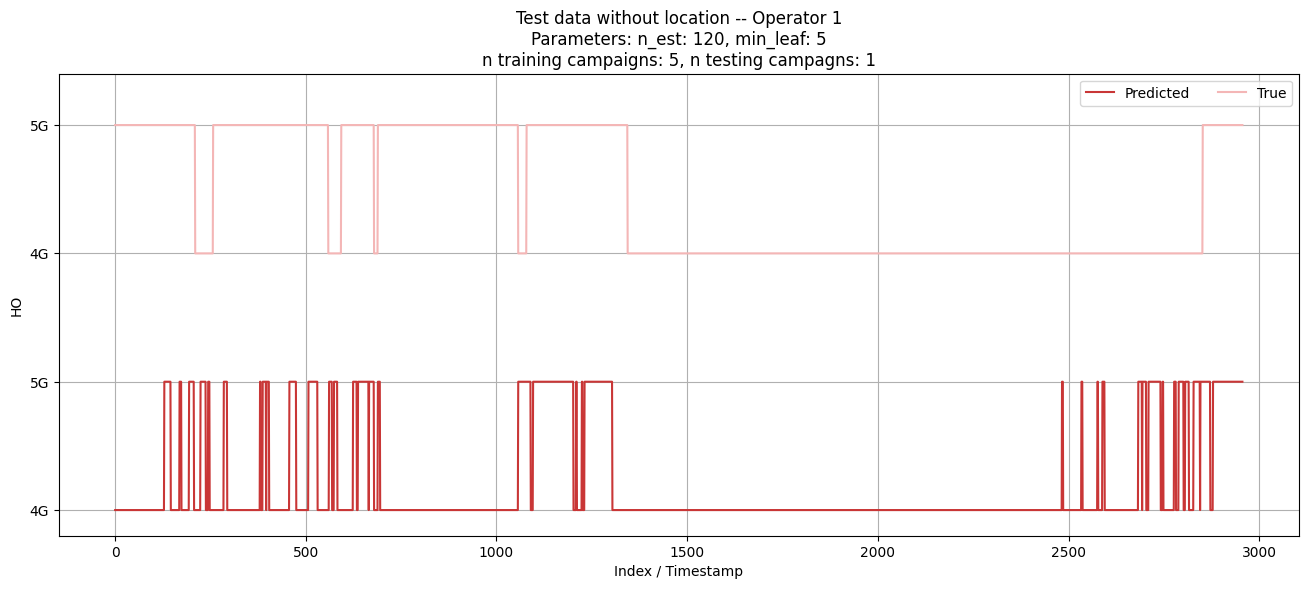

In [213]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [214]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.664      0.875   0.299           0.999   
1      n_est: 5, min_leaf: 2     0.679      0.920   0.317           0.998   
2      n_est: 5, min_leaf: 5     0.676      0.957   0.296           0.996   
3      n_est: 5, min_leaf: 7     0.733      0.929   0.442           0.994   
4      n_est: 5, min_leaf: 9     0.707      0.871   0.414           0.994   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.743      0.947   0.456           0.997   
73   n_est: 300, min_leaf: 7     0.729      0.944   0.425           0.996   
74   n_est: 300, min_leaf: 9     0.715      0.936   0.396           0.996   
75  n_est: 300, min_leaf: 12     0.728      0.943   0.423           0.994   
76  n_est: 300, min_leaf: 15     0.729      0.924   0.437           0.993   

    Precision_train  Recall_train  
0             0.998         0.998  
1             0.994         0.996  
2             0.986         0.996  
3             0.978         0.996  
4             0.978         0.996  
..              ...           ...  
72            0.989         0.998  
73            0.986         0.997  
74            0.984         0.997  
75            0.977         0.997  
76            0.973         0.997  

[77 rows x 7 columns]

In [215]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.712
Mean precision: 0.933
Mean recall: 0.391


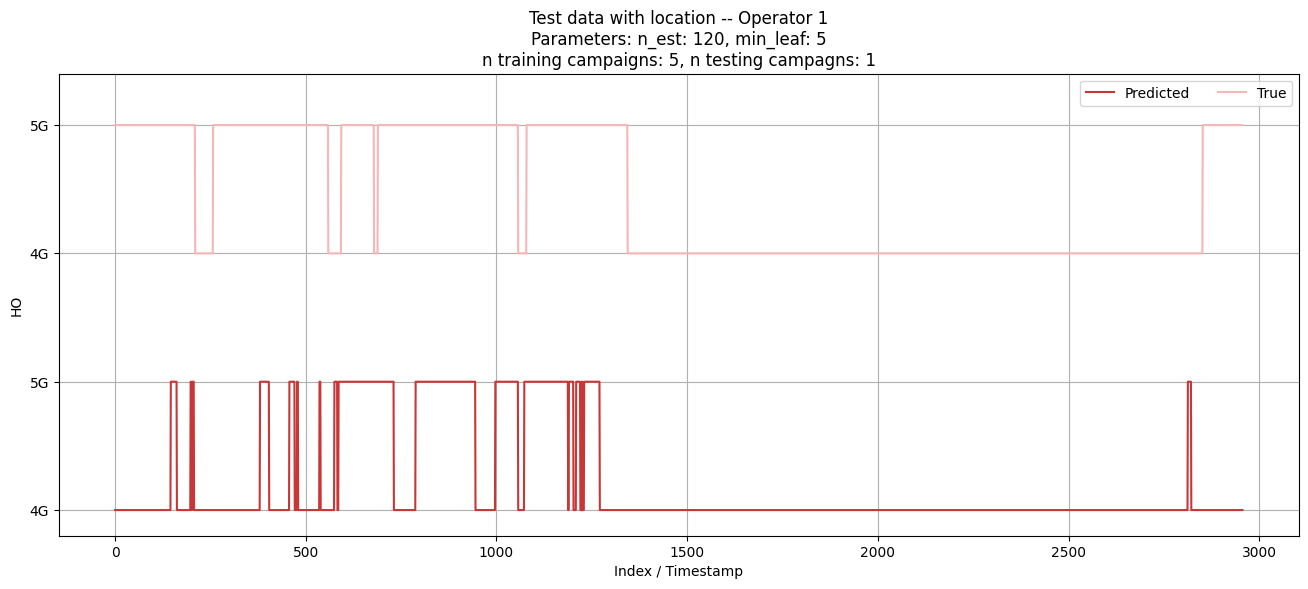

In [216]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Overlap 2

In [225]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_2[0]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap_2[1]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [226]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.837        0.0     0.0           1.000   
1      n_est: 5, min_leaf: 2     0.853        0.0     0.0           0.999   
2      n_est: 5, min_leaf: 5     0.822        0.0     0.0           0.998   
3      n_est: 5, min_leaf: 7     0.831        0.0     0.0           0.996   
4      n_est: 5, min_leaf: 9     0.850        0.0     0.0           0.999   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.852        0.0     0.0           0.999   
73   n_est: 300, min_leaf: 7     0.849        0.0     0.0           0.999   
74   n_est: 300, min_leaf: 9     0.849        0.0     0.0           0.995   
75  n_est: 300, min_leaf: 12     0.842        0.0     0.0           0.996   
76  n_est: 300, min_leaf: 15     0.844        0.0     0.0           0.992   

    Precision_train  Recall_train  
0             0.999         1.000  
1             0.999         0.996  
2             0.994         0.998  
3             0.989         0.995  
4             0.999         0.996  
..              ...           ...  
72            0.999         0.997  
73            0.999         0.998  
74            0.990         0.993  
75            0.989         0.994  
76            0.983         0.986  

[77 rows x 7 columns]

In [227]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.846
Mean precision: 0.000
Mean recall: 0.000


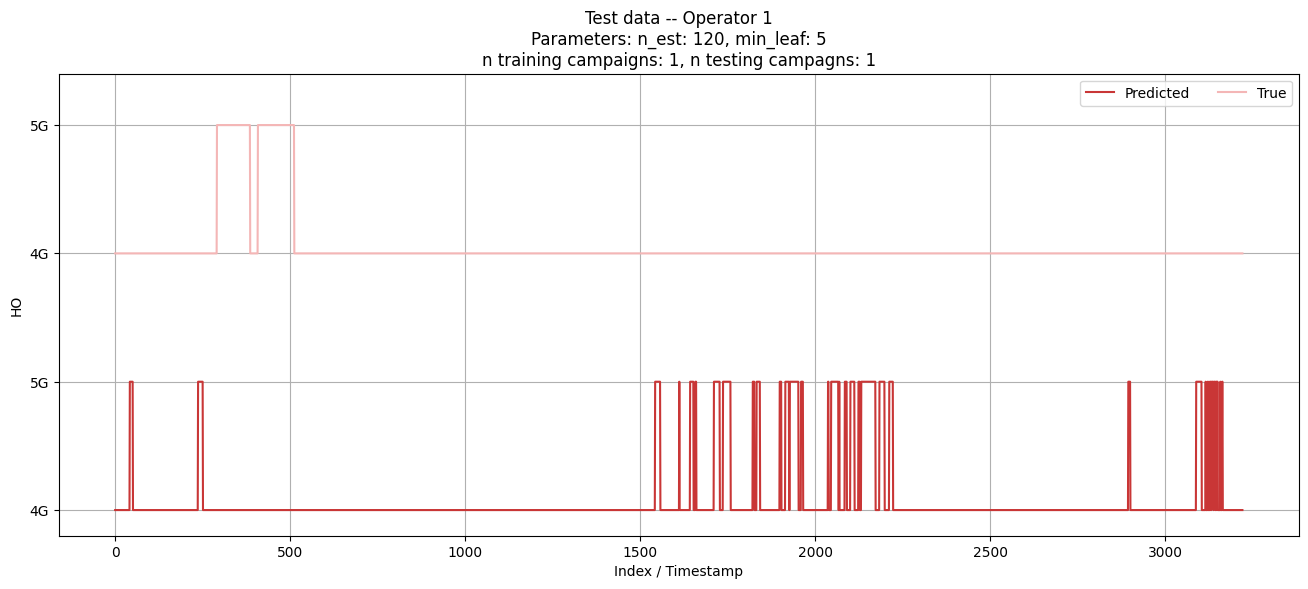

In [228]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

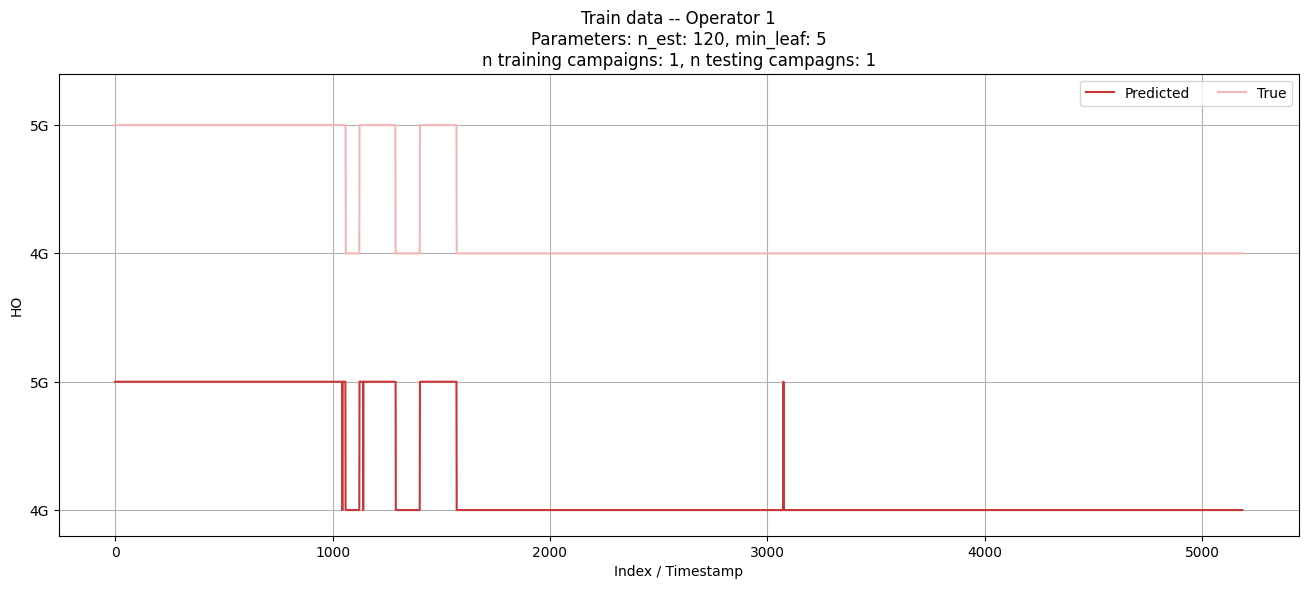

In [229]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [230]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.925        0.0     0.0           1.000   
1      n_est: 5, min_leaf: 2     0.930        0.0     0.0           1.000   
2      n_est: 5, min_leaf: 5     0.926        0.0     0.0           0.999   
3      n_est: 5, min_leaf: 7     0.922        0.0     0.0           1.000   
4      n_est: 5, min_leaf: 9     0.936        0.0     0.0           0.999   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.929        0.0     0.0           1.000   
73   n_est: 300, min_leaf: 7     0.930        0.0     0.0           1.000   
74   n_est: 300, min_leaf: 9     0.934        0.0     0.0           1.000   
75  n_est: 300, min_leaf: 12     0.932        0.0     0.0           1.000   
76  n_est: 300, min_leaf: 15     0.931        0.0     0.0           0.999   

    Precision_train  Recall_train  
0             0.999         1.000  
1             0.999         1.000  
2             0.998         1.000  
3             1.000         0.999  
4             0.999         0.996  
..              ...           ...  
72            0.999         1.000  
73            0.999         0.999  
74            1.000         1.000  
75            1.000         1.000  
76            0.996         1.000  

[77 rows x 7 columns]

In [231]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.931
Mean precision: 0.000
Mean recall: 0.000


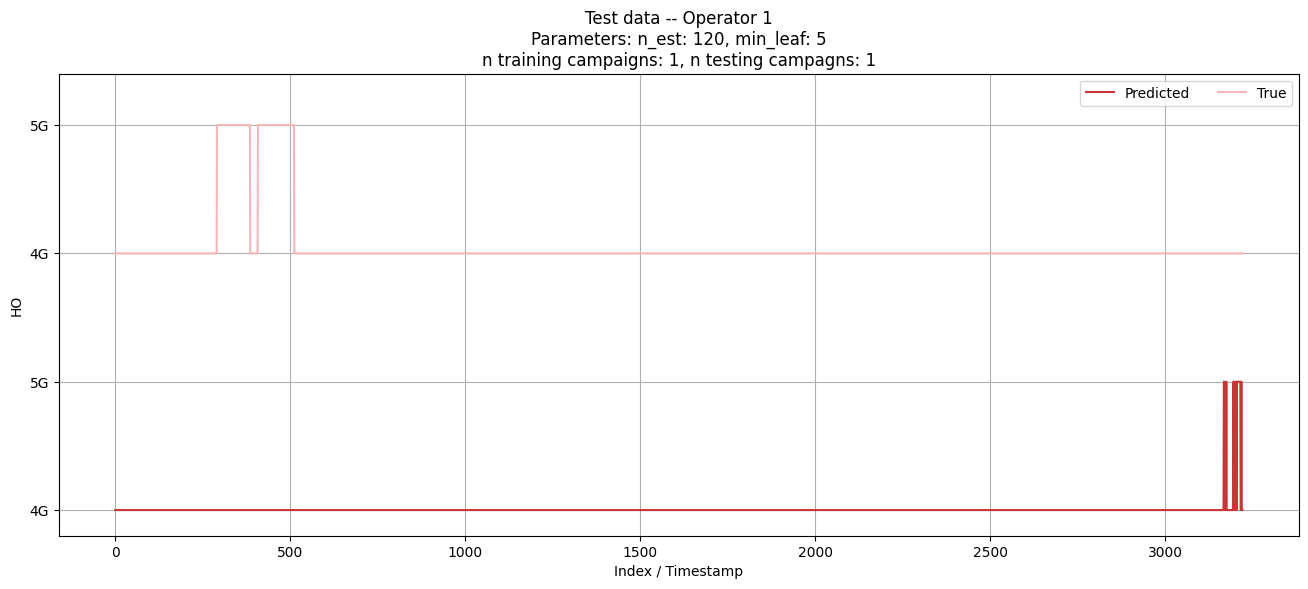

In [232]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

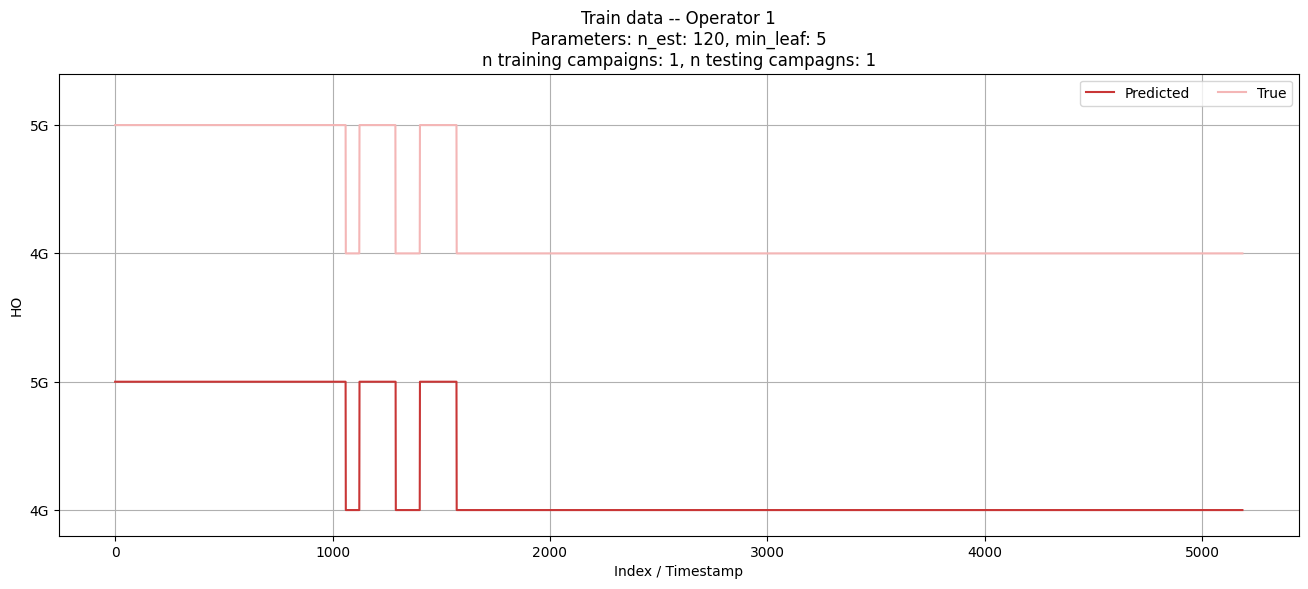

In [233]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- Operator 1\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()